## Training an RNN with Text Data

#### Load Libraries

In [1]:
import urllib2
import PIL
import os
import numpy as np
import math
import PIL.Image as Image
import pandas as pd
import re
import matplotlib.pyplot as plt


In [2]:
'''Trains a LSTM on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard

Using TensorFlow backend.


#### Set up Text Cleaner function

In [3]:
# Set up helper cleaner function
def cleaner(cell):
    line = str(cell)
    line = line.replace('[u', '').replace(']', '').replace(',', '').replace("u'", '').replace("'", '')
    line = re.sub("(^|\W)\d+($|\W)", " ", line)
    line = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", line)
    line = re.sub(r"\'s", " \'s", line)
    line = re.sub(r"\'ve", " \'ve", line)
    line = re.sub(r"n\'t", " n\'t", line)
    line = re.sub(r"\'re", " \'re", line)
    line = re.sub(r"\'d", " \'d", line)
    line = re.sub(r"\'ll", " \'ll", line)
    line = re.sub(r",", " , ", line)
    line = re.sub(r"!", " ! ", line)
    line = re.sub(r"\(", " \( ", line)
    line = re.sub(r"\)", " \) ", line)
    line = re.sub(r"\?", " \? ", line)
    line = re.sub(r"\s{2,}", " ", line)
    return line

#### Prepare and Clean Data

In [4]:
# load train
train = pd.read_csv("milestone_4/train_full.csv")

# drop rogue column
train.drop("Unnamed: 0", axis=1, inplace=True)

# alias a copy
curr_df = train.copy()

# Store target labels
string_y = curr_df.ix[:,0:19] 

# create matrix of data's string values
string_cols = ["director", "lead actors", "overview", "title"]
string_matrix = curr_df[string_cols]

# trim trailing and leading spaces
string_matrix = string_matrix.apply(lambda col: col.str.strip())

# combine text columns into one
total = string_matrix['director'] + " " + string_matrix['lead actors'] + " " + string_matrix['overview'] + " " + string_matrix['title']

# clean up and save
total = total.apply(cleaner)
total = total.apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
text_train = pd.DataFrame(total)

## Preprocess Text Data

In [5]:
# set global params
max_features = 2000
maxlen = 1000 

# tokenize data
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text_train.ix[:].values.ravel())
sequences = tokenizer.texts_to_sequences(text_train.ix[:].values.ravel() )
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

# pad data to be standard
data = pad_sequences(sequences, maxlen=800)

print('Shape of data tensor:', data.shape)


Found 28518 unique tokens.
Shape of data tensor: (7220, 800)


#### Consolidate targets for one model

In [6]:
# simplify labels for training
labels = pd.DataFrame() 
labels["other"] = ""
labels["heartbeat"] = ""
labels["lighthearted"] = ""

for index, row in string_y.iterrows():
    if row["36"] == 1 or row["37"] == 1 or row["10770"] == 1:
        labels.set_value(index, "other", 1)
    else:
        labels.set_value(index, "other", 0)
        
    if row["12"] == 1 or row["14"] == 1 or row["18"] == 1 or row["27"] == 1 or row["28"] == 1 or row["53"] == 1 or row["80"] == 1 or row["10749"] == 1 or row["10752"] == 1:
        labels.set_value(index, "heartbeat", 1)
    else:
        labels.set_value(index, "heartbeat", 0)
        
    if row["16"] == 1 or row["35"] == 1 or row["10402"] == 1 or row["10751"] == 1:
        labels.set_value(index, "lighthearted", 1)
    else:
        labels.set_value(index, "lighthearted", 0)

In [7]:
# also store the 19 labels to compare
old_labels = string_y

In [8]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (7220, 800)
Shape of label tensor: (7220, 3)


#### Create and format train and test data

In [9]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

#sub select
data = data[indices]

# prep labels
labels = labels.values
labels = labels[indices]

# prep old labels
old_labels = old_labels.values
old_labels = old_labels[indices]

# format data and split
nb_validation_samples = int(.3 * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# format old labels and split
y_train_old = old_labels[:-nb_validation_samples]
y_val_old = old_labels[-nb_validation_samples:]

print(x_train.shape)
print(y_train.shape)
print(y_train_old.shape)
print(y_val_old.shape)

(5054, 800)
(5054, 3)
(5054, 19)
(2166, 19)


## Build Models 

Here we will compare the accuracy of the RNN predicting the three label description of movies along with the full 19.

#### Set up Model Plotting Function

In [10]:
def plot_acc(model_history):
    plt.figure(figsize=(8, 6))

    max_train_acc = round(max(model_history.history['acc']), 2)
    max_test_acc = round(max(model_history.history['val_acc']), 2)

    plt.plot(model_history.history['acc'], 
             label="Train Acc (Max = {0})".format(max_train_acc))
    plt.plot(model_history.history['val_acc'], 
             label="Test Acc (Max = {0})".format(max_test_acc))

    plt.title("Model accuracy as a function of epochs")
    plt.xlabel("epoch")
    plt.legend(loc="lower right")
    plt.ylabel("accuracy")
    plt.show()

In [11]:
print('Build model with 3 data targets...')
model_3 = Sequential()
model_3.add(Embedding(max_features, 400))
model_3.add(LSTM(3, dropout=0.2, recurrent_dropout=0.2))

# try using different optimizers and different optimizer configs
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_3.summary()

Build model with 3 data targets...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 400)         800000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 3)                 4848      
Total params: 804,848.0
Trainable params: 804,848
Non-trainable params: 0.0
_________________________________________________________________


In [12]:
print('Build model with 19 data targets...')
model_19 = Sequential()
model_19.add(Embedding(max_features, 400))
model_19.add(LSTM(19, dropout=0.2, recurrent_dropout=0.2))

# try using different optimizers and different optimizer configs
model_19.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_19.summary()

Build model with 19 data targets...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 400)         800000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 19)                31920     
Total params: 831,920.0
Trainable params: 831,920
Non-trainable params: 0.0
_________________________________________________________________


#### Training model with 3 label targets

Train on 5054 samples, validate on 2166 samples
Epoch 1/20
5054/5054 [==============================] - 21s - loss: 0.4572 - acc: 0.7876 - val_loss: 0.5135 - val_acc: 0.7813

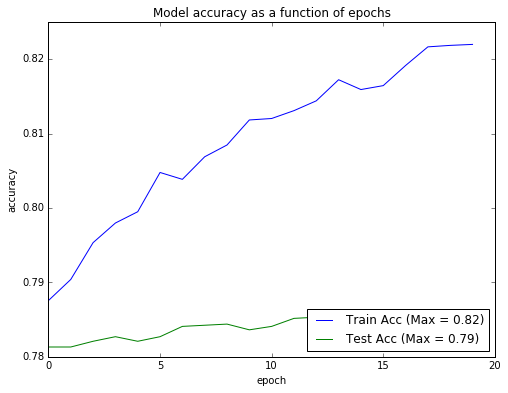

In [14]:
# happy learning!
history_3 = model_3.fit(x_train, y_train,
                    batch_size=361,
                    epochs=20,
                    validation_data=(x_val, y_val))
plot_acc(history_3)   

#### Training model with 19 label targets

Train on 5054 samples, validate on 2166 samples
Epoch 1/20
5054/5054 [==============================] - 22s - loss: 1.0733 - acc: 0.8404 - val_loss: 0.7650 - val_acc: 0.8382

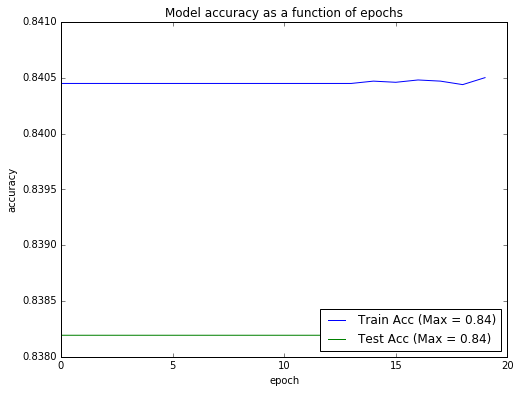

In [16]:
# happy learning!
history_19 = model_19.fit(x_train, y_train_old,
                    batch_size=361,
                    epochs=20,
                    validation_data=(x_val, y_val_old))
plot_acc(history_19)       

### Model Discussion

Here we see that our target 19 model taks substantial time to get even a slight change. Here, when we collapse the target data into three generalizable themes we see that our model performs at a .8 accuracy with the baseline being .5. Here, we see that our model can make relatively informed estimates of the type of movie from the text associated with it. With more traing time, we could expect that accuracy to increase. 